In [64]:
import random
import math
import re
import pandas as pd
import numpy as np

from sklearn import decomposition

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import BayesianGaussianMixture
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
random.seed(11915043)

<H2> P1 : IRIS – HIERARCHICAL FISHER </H2>

In [3]:
iris = pd.read_csv('DMG-2 Assignment Data Files/iris/iris.data', header=None, names =
                   ['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])
iris.sample(5)

,sepal length,sepal width,petal length,petal width,class
140,6.7,3.1,5.6,2.4,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica
3,4.6,3.1,1.5,0.2,Iris-setosa
142,5.8,2.7,5.1,1.9,Iris-virginica
103,6.3,2.9,5.6,1.8,Iris-virginica


### Two classes in IRIS are more “similar” to each other. Find which ones using scatter plots. Lets say class 1 and class 2.

As seen in plots below 'Iris-versicolor' and 'Iris-virginica' are more similar to each other

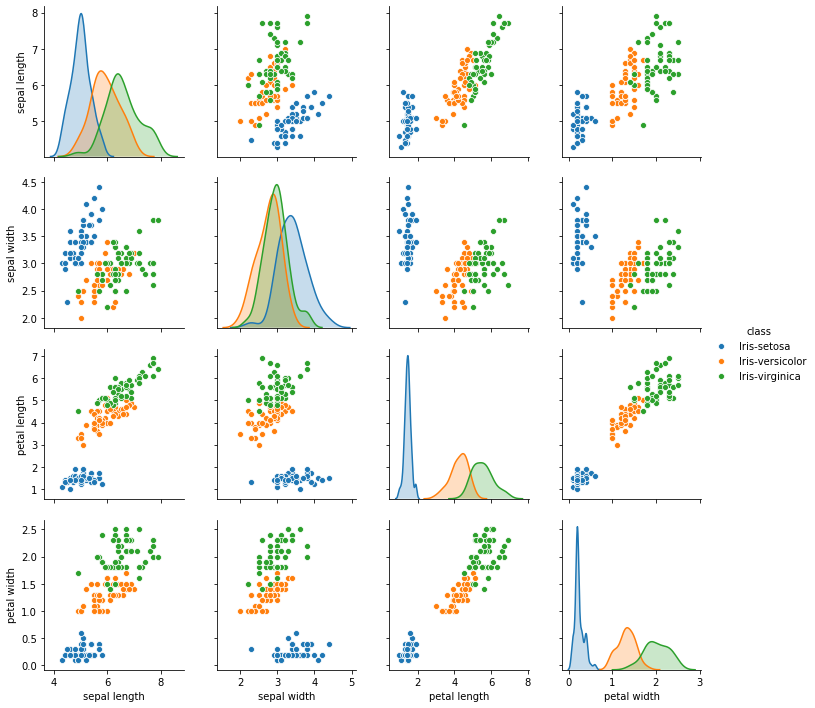

In [4]:
sns.pairplot(iris, hue = 'class')

### Lets create a “meta class” combining class 1 and class 2 (or whichever are the two most similar classes). Lets call it class 4.

In [5]:
iris['versi-virgi'] = np.where((iris['class'] == 'Iris-versicolor') | (iris['class'] == 'Iris-virginica'), 1, 0)
iris.sample(5)

,sepal length,sepal width,petal length,petal width,class,versi-virgi
69,5.6,2.5,3.9,1.1,Iris-versicolor,1
66,5.6,3.0,4.5,1.5,Iris-versicolor,1
3,4.6,3.1,1.5,0.2,Iris-setosa,0
8,4.4,2.9,1.4,0.2,Iris-setosa,0
61,5.9,3.0,4.2,1.5,Iris-versicolor,1


In [6]:
train, test = train_test_split(iris, test_size=0.3)

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


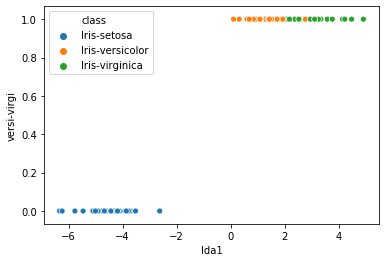

In [7]:
#Ref https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html

lda = LinearDiscriminantAnalysis()
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
target = 'versi-virgi'

lda1 = lda.fit(train[features], train[target])
lda1_dis = lda1.transform(train[features])
train['lda1'] = lda1_dis

ax = sns.scatterplot(x="lda1", y="versi-virgi", hue="class", data=train)


/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


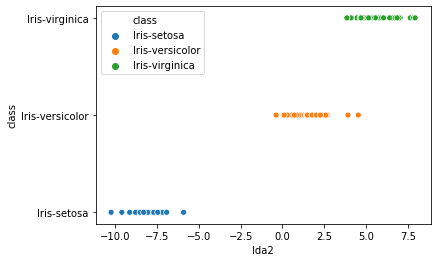

In [8]:
features = ['sepal length', 'sepal width', 'petal length', 'petal width','lda1']
target = 'class'

lda = LinearDiscriminantAnalysis(n_components=1)
lda2 = lda.fit(train[features], train[target])
lda2_dis = lda2.transform(train[features])
train['lda2'] = lda2_dis

ax = sns.scatterplot(x="lda2", y="class", hue="class", data=train)

In [9]:
test['lda1'] = lda1.transform(test[['sepal length', 'sepal width', 'petal length', 'petal width']])
test['lda2'] = lda2.transform(test[['sepal length', 'sepal width', 'petal length', 'petal width', 'lda1']])

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


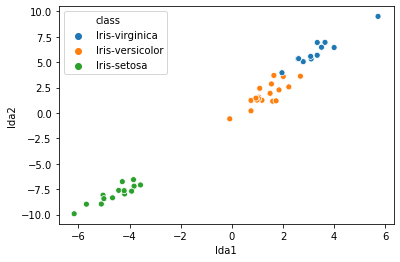

In [10]:
ax = sns.scatterplot(x="lda1", y="lda2", hue="class", data=test)

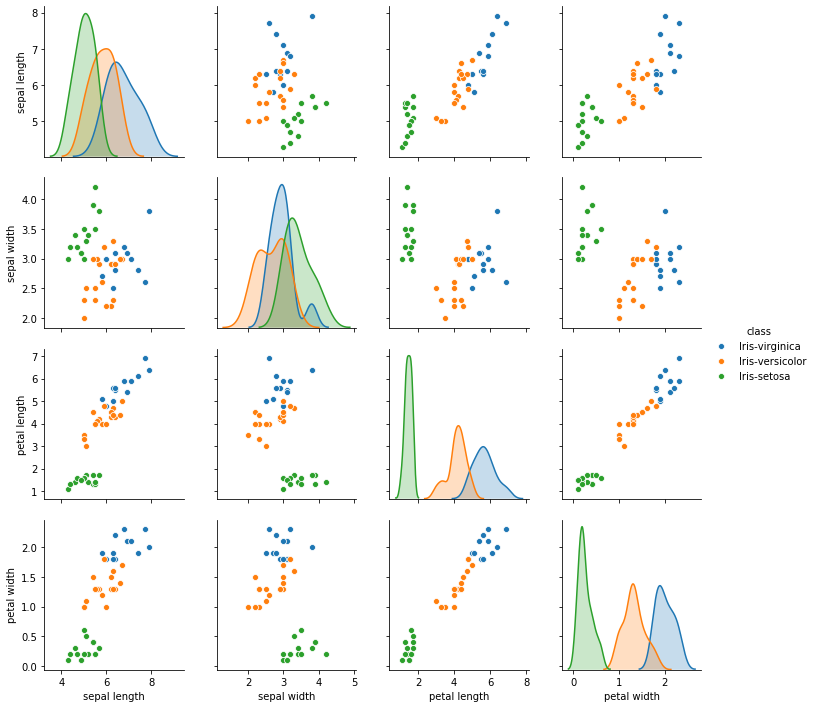

In [11]:
sns.pairplot(hue='class', data=test[['sepal length', 'sepal width', 'petal length', 'petal width', 'class']])

<H2> P2 : MUSHROOM information gain </H2>

Take the MUSHROOM training data. There are 20+ features and 2 classes. We want to find the BEST feature using the three purity measures: Accuracy, Gini Index, and Entropy.

In [12]:
col_names = ['class',
             'cap-shape',
             'cap-surface',
             'cap-color',
             'bruises',
             'odor',
             'gill-attachment',
             'gill-spacing',
             'gill-size',
             'gill-color',
             'stalk-shape',
             'stalk-root',
             'stalk-surface-above-ring',
             'stalk-surface-below-ring',
             'stalk-color-above-ring',
             'stalk-color-below-ring',
             'veil-type',
             'veil-color',
             'ring-number',
             'ring-type',
             'spore-print-color',
             'population',
             'habitat']
mushroom = pd.read_csv('DMG-2 Assignment Data Files/Mushroom/agaricus-lepiota.data',
                       index_col=None,
                       header=None,
                       names=col_names)
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### For each feature, partition the data into k regions where k is the number of values the feature can take.

- Take one feature at a time from dataframe
- create a subset of data with that feature and class labels
- Groupby count to partition data into K features where k is no of values feature can take

#### Now, for each partition 
- 

In [13]:
result_set = pd.DataFrame(columns = ['Feature', 'Accuracy', 'Gini', '1-Entropy'])
result_set

,Feature,Accuracy,Gini,1-Entropy


In [14]:
total_rows_data = mushroom.shape[0]

for column in col_names[1:] :
    df_feature_subset = mushroom[[column,'class']]
    feature_partition = df_feature_subset.groupby([column,'class']).size().unstack(fill_value=0)
    
    #Ref : https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb
    for index, row in feature_partition.iterrows():
        partition_total_sum = row['e'] + row['p']
        prob_e_class = row['e']/partition_total_sum
        prob_p_class = row['p']/partition_total_sum

        # calculate accuracy for each partition
        if(row['e'] > row['p']) :
            feature_partition.at[index,'Parition Accuracy'] = prob_e_class
        else :
            feature_partition.at[index,'Parition Accuracy'] = prob_p_class
        feature_partition.at[index,'Weighted Accuracy'] = partition_total_sum*feature_partition.loc[index,'Parition Accuracy']/total_rows_data

        #calculate gini index for each partition
        feature_partition.at[index,'Gini Index'] = prob_e_class**2 + prob_p_class**2
        feature_partition.at[index,'Weighted Gini Index'] = partition_total_sum*feature_partition.loc[index,'Gini Index']/total_rows_data

        #calculate entropy for each partition
        entropy = 0
        num_of_partitions = feature_partition.shape[0]
        if(num_of_partitions > 1) :
            print(num_of_partitions)
            if(prob_e_class > 0) :
                entropy += prob_e_class*math.log(prob_e_class, num_of_partitions)
            if(prob_p_class > 0) :
                entropy += prob_p_class*math.log(prob_p_class, num_of_partitions)
        feature_partition.at[index,'Entropy'] = -1*entropy
        feature_partition.at[index,'Weighted Entropy'] = partition_total_sum*feature_partition.loc[index,'Entropy']/total_rows_data
        print(feature_partition)
        print()
    
    result_set = result_set.append({'Feature' : column, 
                       'Accuracy': feature_partition[['Weighted Accuracy']].sum()[0].round(4),
                       'Gini' : feature_partition[['Weighted Gini Index']].sum()[0].round(4),
                       '1-Entropy': 1-feature_partition[['Weighted Entropy']].sum()[0].round(4)}, ignore_index=True)
    
result_set.head()

6
class         e     p  Parition Accuracy  Weighted Accuracy  Gini Index  \
cap-shape                                                                 
b           404    48           0.893805           0.049729    0.810165   
c             0     4                NaN                NaN         NaN   
f          1596  1556                NaN                NaN         NaN   
k           228   600                NaN                NaN         NaN   
s            32     0                NaN                NaN         NaN   
x          1948  1708                NaN                NaN         NaN   

class      Weighted Gini Index   Entropy  Weighted Entropy  
cap-shape                                                   
b                     0.045076  0.188912          0.010511  
c                          NaN       NaN               NaN  
f                          NaN       NaN               NaN  
k                          NaN       NaN               NaN  
s                          NaN 

12
class         e     p  Parition Accuracy  Weighted Accuracy  Gini Index  \
gill-color                                                                
b             0  1728                1.0           0.212703         1.0   
e            96     0                NaN                NaN         NaN   
g           248   504                NaN                NaN         NaN   
h           204   528                NaN                NaN         NaN   
k           344    64                NaN                NaN         NaN   
n           936   112                NaN                NaN         NaN   
o            64     0                NaN                NaN         NaN   
p           852   640                NaN                NaN         NaN   
r             0    24                NaN                NaN         NaN   
u           444    48                NaN                NaN         NaN   
w           956   246                NaN                NaN         NaN   
y            64    22 

y                                    NaN  

9
class                      e     p  Parition Accuracy  Weighted Accuracy  \
stalk-color-below-ring                                                     
b                          0   432           1.000000           0.053176   
c                          0    36           1.000000           0.004431   
e                         96     0           1.000000           0.011817   
g                        576     0           1.000000           0.070901   
n                         64   448           0.875000           0.055145   
o                        192     0           1.000000           0.023634   
p                        576  1296           0.692308           0.159527   
w                       2704  1680           0.616788           0.332841   
y                          0    24                NaN                NaN   

class                   Gini Index  Weighted Gini Index   Entropy  \
stalk-color-below-ring                          

y                           NaN       NaN               NaN  

6
class          e     p  Parition Accuracy  Weighted Accuracy  Gini Index  \
population                                                                 
a            384     0           1.000000           0.047267    1.000000   
c            288    52           0.847059           0.035451    0.740900   
n            400     0           1.000000           0.049237    1.000000   
s            880   368           0.705128           0.108321    0.584155   
v           1192  2848                NaN                NaN         NaN   
y           1064   648                NaN                NaN         NaN   

class       Weighted Gini Index   Entropy  Weighted Entropy  
population                                                   
a                      0.047267 -0.000000         -0.000000  
c                      0.031008  0.238747          0.009992  
n                      0.049237 -0.000000         -0.000000  
s               

,Feature,Accuracy,Gini,1-Entropy
0,cap-shape,0.5643,0.5308,0.6324
1,cap-surface,0.5805,0.5200,0.5148
2,cap-color,0.5953,0.5245,0.7101
3,bruises,0.7440,0.6262,0.1933
4,odor,0.9852,0.9715,0.9707


In [15]:
result_set.tail()

,Feature,Accuracy,Gini,1-Entropy
17,ring-number,0.5382,0.5237,0.3939
18,ring-type,0.7755,0.6824,0.7067
19,spore-print-color,0.8680,0.7835,0.8365
20,population,0.7218,0.6193,0.6916
21,habitat,0.6903,0.5974,0.7000


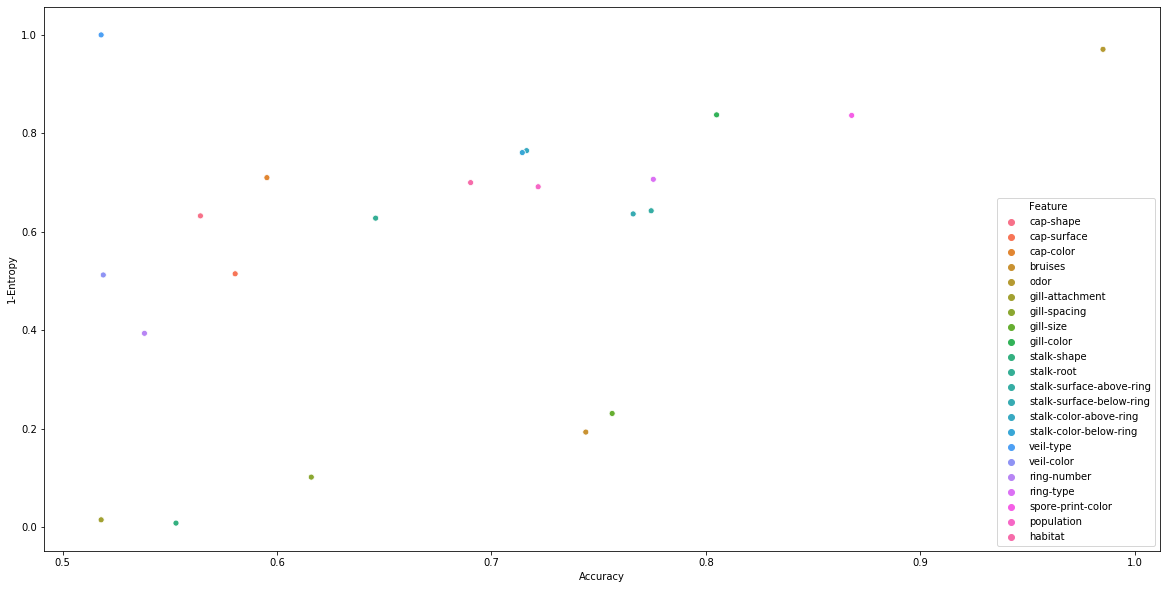

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x='Accuracy', y='1-Entropy', hue='Feature', data=result_set)

In [17]:
result_set.sort_values(by='1-Entropy', ascending=False)

,Feature,Accuracy,Gini,1-Entropy
15,veil-type,0.5180,0.5006,1.0000
4,odor,0.9852,0.9715,0.9707
8,gill-color,0.8050,0.7321,0.8376
19,spore-print-color,0.8680,0.7835,0.8365
13,stalk-color-above-ring,0.7164,0.6382,0.7649
14,stalk-color-below-ring,0.7144,0.6329,0.7610
2,cap-color,0.5953,0.5245,0.7101
18,ring-type,0.7755,0.6824,0.7067
21,habitat,0.6903,0.5974,0.7000
20,population,0.7218,0.6193,0.6916


<h2> P3 : MUSHROOM NB/DT </h2>

In [18]:
col_names = ['class',
             'cap-shape',
             'cap-surface',
             'cap-color',
             'bruises',
             'odor',
             'gill-attachment',
             'gill-spacing',
             'gill-size',
             'gill-color',
             'stalk-shape',
             'stalk-root',
             'stalk-surface-above-ring',
             'stalk-surface-below-ring',
             'stalk-color-above-ring',
             'stalk-color-below-ring',
             'veil-type',
             'veil-color',
             'ring-number',
             'ring-type',
             'spore-print-color',
             'population',
             'habitat']
mushroom = pd.read_csv('DMG-2 Assignment Data Files/Mushroom/agaricus-lepiota.data',
                       index_col=None,
                       header=None,
                       names=col_names)
mushroom.head()

X = mushroom.loc[:, mushroom.columns != 'class']
X = pd.get_dummies(X)
y = mushroom.loc[:, mushroom.columns == 'class']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

df = pd.DataFrame(columns=['lambda','accuracy'])
for i in range(1,51) :
    clf = BernoulliNB(alpha=i)
    clf.fit(X_train, y_train)
    score = accuracy_score(y_test, clf.predict(X_test))
    df = df.append({'lambda' : i,'accuracy':score}, ignore_index=True)
    print(i, score)

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

1 0.9339622641509434
2 0.9278096800656276
3 0.92616899097621
4 0.9257588187038556
5 0.9241181296144381
6 0.9232977850697293
7 0.920836751435603
8 0.920836751435603
9 0.9200164068908941
10 0.918785890073831


/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

11 0.9183757178014766
12 0.9183757178014766
13 0.9175553732567678
14 0.9171452009844134
15 0.9163248564397046
16 0.9163248564397046
17 0.9163248564397046
18 0.9163248564397046
19 0.9150943396226415
20 0.9146841673502871


/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

21 0.9142739950779327
22 0.9142739950779327
23 0.9138638228055783
24 0.9130434782608695
25 0.9126333059885152
26 0.9126333059885152
27 0.9126333059885152
28 0.9126333059885152
29 0.9126333059885152
30 0.9122231337161608


/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

31 0.9118129614438064
32 0.9118129614438064
33 0.9109926168990976
34 0.9109926168990976
35 0.9109926168990976
36 0.9109926168990976
37 0.9101722723543888
38 0.9101722723543888
39 0.9101722723543888
40 0.9093519278096801


/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

41 0.9085315832649713
42 0.9081214109926169
43 0.9081214109926169
44 0.9081214109926169
45 0.9081214109926169
46 0.9077112387202625
47 0.9077112387202625
48 0.9077112387202625
49 0.9077112387202625
50 0.9073010664479081


/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


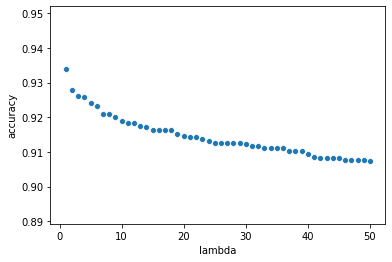

In [20]:
x = sns.scatterplot(x="lambda", y="accuracy", data=df)

In [21]:
from sklearn.tree import DecisionTreeClassifier

df = pd.DataFrame(columns=['lambda','accuracy'])
for i in range(4,65,4) :
    clf = DecisionTreeClassifier(min_samples_split=i)
    clf.fit(X_train, y_train)
    score = accuracy_score(y_test, clf.predict(X_test))
    df = df.append({'lambda' : i,'accuracy':score}, ignore_index=True)
    print(i, score)

4 1.0
8 1.0
12 1.0
16 1.0
20 1.0
24 1.0
28 1.0
32 1.0
36 1.0
40 1.0
44 0.9983593109105825
48 0.9983593109105825
52 0.9983593109105825
56 0.9983593109105825
60 0.9983593109105825
64 0.9983593109105825


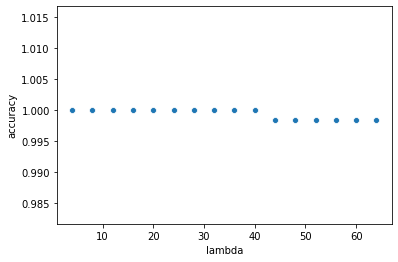

In [22]:
x = sns.scatterplot(x="lambda", y="accuracy", data=df)

<H2> P4 : MNIST Bayesian </H2>

In [23]:
mnist = pd.read_csv('DMG-2 Assignment Data Files/MNIST/train.csv')
mnist.head()

mnist_data = mnist.loc[:, mnist.columns != 'label']
mnist_label = mnist.loc[:, mnist.columns == 'label']

In [24]:
pca = decomposition.PCA()
pca.n_components = 9
pca_data = pca.fit_transform(mnist_data)

In [25]:
model = LinearDiscriminantAnalysis(n_components=9)
model.fit(mnist_data, mnist_label)
mnist_fisher_proj_data = model.transform(mnist_data)

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [32]:
X_train, X_test, y_train, y_test = train_test_split(pca_data, mnist['label'], test_size=0.3)

In [51]:
#https://scikit-learn.org/stable/modules/mixture.html#bgmm
#https://www.programcreek.com/python/example/99731/sklearn.mixture.BayesianGaussianMixture

bgm = BayesianGaussianMixture(
            n_components=9,
            covariance_type='spherical',
            max_iter=300
        )
bgm.fit(X_train, y_train)
y_pred = bgm.predict(X_test)
print(metrics.f1_score(y_test, y_pred, average='weighted'))


0.09462745276265579


/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best bandwidth: 3.79269019073225


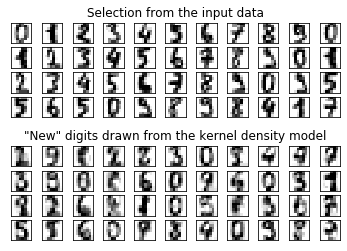

In [46]:
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity


import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# load the data
digits = load_digits()

# project the 64-dimensional data to a lower dimension
pca = PCA(n_components=15, whiten=False)
data = pca.fit_transform(digits.data)

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

# sample 44 new points from the data
new_data = kde.sample(44, random_state=0)
new_data = pca.inverse_transform(new_data)

# turn data into a 4x11 grid
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# plot real digits and resampled digits
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)

ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('"New" digits drawn from the kernel density model')

plt.show()

<h2> P6 : News group Text Classifier </h2>

In [59]:
#https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/
#https://medium.com/@dobko_m/nlp-text-data-cleaning-and-preprocessing-ea3ffe0406c1

from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [61]:
news_group_dataset = documents

In [66]:
news_group_dataset = re.sub("[!@#$+%*:()'-]", ' ', news_group_dataset)
news_group_dataset

TypeError: expected string or bytes-like object

In [65]:
# removing everything except alphabets`

text = re.sub("[!@#$+%*:()'-]", ' ', text)
news_group_dataset = news_group_dataset.str.replace("[^a-zA-Z#]", " ")

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

NameError: name 'text' is not defined